<a href="https://colab.research.google.com/github/deepshikha04yadav/Traffic-Gesture-Detection-for-Automotive/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics mediapipe opencv-python-headless torch torchvision torchaudio kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 57.1 MB/s eta 0:00:00

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhishekdhakad8055/traffic-police-gesture-dataset")

print("Path to dataset files:", path)

100%|██████████| 116M/116M [00:06<00:00, 19.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1


In [6]:
import os

base_dir = "/root/.cache/kagglehub/datasets/abhishekdhakad8055/traffic-police-gesture-dataset/versions/1/Traffic Police Gesture dataset/Traffic police gesture/Train"

for folder in os.listdir(base_dir):
    print(folder, ":", len(os.listdir(os.path.join(base_dir, folder))), "images")


stop signal : 100 images
left over : 100 images
left turn 1 : 100 images
right turn : 100 images
lane left : 100 images
left : 100 images
move straight : 100 images
lane right : 100 images
right : 100 images
right over : 100 images


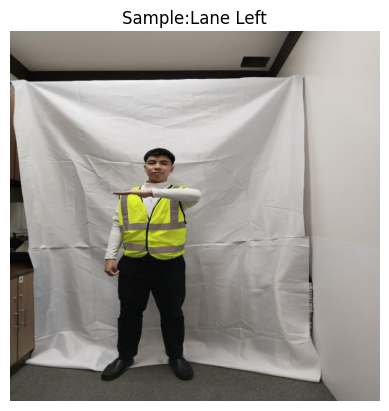

In [11]:
import cv2
import matplotlib.pyplot as plt
import os

# example image from "left lane" folder
img_path = os.path.join(base_dir, "lane left", os.listdir(os.path.join(base_dir, "lane left"))[0])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Sample:Lane Left")
plt.axis("off")
plt.show()
